# ETL Y EDA PURCHASES PRICES 2017

In [1]:
#Importamos las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Cargamos el archivo csv y nombramos dataset
PurchasesPrices = pd.read_csv("2017PurchasePricesDec.csv")


In [3]:
#Informacion el dataset
PurchasesPrices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           12261 non-null  int64  
 1   Description     12260 non-null  object 
 2   Price           12261 non-null  float64
 3   Size            12260 non-null  object 
 4   Volume          12260 non-null  object 
 5   Classification  12261 non-null  int64  
 6   PurchasePrice   12261 non-null  float64
 7   VendorNumber    12261 non-null  int64  
 8   VendorName      12261 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 862.2+ KB


In [4]:
#Primeras filas
PurchasesPrices.head()

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


In [5]:
#Verificamos valores nulos en cada columna
print("\nValores nulos por columna:")
print(PurchasesPrices.isnull().sum())


Valores nulos por columna:
Brand             0
Description       1
Price             0
Size              1
Volume            1
Classification    0
PurchasePrice     0
VendorNumber      0
VendorName        0
dtype: int64


In [6]:
#Averiguamos si existen filas duplicadas
filas_duplicadas = PurchasesPrices.duplicated()

#Hacemos el recuento de las filas duplicadas
contar_filas_duplicadas = filas_duplicadas.sum()

#Mostramos el número de filas duplicadas
print(f'Número de filas duplicadas en la tabla de factura_compras: {contar_filas_duplicadas}')

#Mostramos las filas filas duplicadas 
if contar_filas_duplicadas > 0:
    print("Filas duplicadas en la tabla Producto:")
    print(PurchasesPrices[filas_duplicadas])

Número de filas duplicadas en la tabla de factura_compras: 0


In [7]:
#Verificamos solo las columnas numericas con valores negativos 
negativos = PurchasesPrices.select_dtypes(include=['number']) < 0

# Obtenemos los nombres de las columnas que tienen valores negativos
columnas_negativas = negativos.any()

# Filtramos las columnas que tienen al menos un valor negativo
columnas_con_negativos = columnas_negativas[columnas_negativas].index.tolist()

# Imprimimos los resultados
if columnas_con_negativos:
    print(f"Columnas con valores negativos: {columnas_con_negativos}")
    for column in columnas_con_negativos:
        print(f"\nValores negativos en la columna '{column}':")
        print(PurchasesPrices[PurchasesPrices[column] < 0]) # muestra las filas negativas
else:
    print("No hay valores negativos en el Dataframe.")

No hay valores negativos en el Dataframe.


In [8]:
#Se borra la columna VendorName para alivianar la base
del PurchasesPrices['VendorName']

In [9]:
#Rellenamos valores nulos en 'Price' con la media
PurchasesPrices['Price'].fillna(PurchasesPrices['Price'].mean(), inplace=True)

#Rellenamos valores nulos en 'PurchasePrice' con la media
PurchasesPrices['PurchasePrice'].fillna(PurchasesPrices['PurchasePrice'].mean(), inplace=True)

#Elimnamos duplicados
PurchasesPrices.drop_duplicates(inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_520\2944711371.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  PurchasesPrices['Price'].fillna(PurchasesPrices['Price'].mean(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_520\2944711371.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [10]:
#Como en los demas archivos se encuestra la misma convercion de la columna Size, creando SizeMl
import re

def convertir_a_ml(size):
    # Expresión regular para extraer el número principal, unidad y posibles cantidades de paquetes
    match = re.match(r"(\d+(\.\d+)?)\s*(mL|L|liter|oz)?(?:\s*(\d+)?\s*Pk)?", str(size), re.IGNORECASE)
    
    if match:
        valor = float(match.group(1))  # Valor numérico principal
        unidad = match.group(3).lower() if match.group(3) else ''  # Unidad de medida
        cantidad_pk = int(match.group(4)) if match.group(4) else 1  # Cantidad en el paquete, por defecto 1
        
        # Convertir a mililitros según la unidad
        if unidad in ['l', 'liter']:
            return valor * 1000 * cantidad_pk  # Convertir litros a mililitros y multiplicar por cantidad
        elif unidad == 'oz':
            return valor * 29.5735 * cantidad_pk  # Convertir onzas a mililitros y multiplicar por cantidad
        elif unidad == 'ml':
            return valor * cantidad_pk  # Ya está en mililitros, multiplicar por cantidad
    return None

# Aplicar la función a la columna 'Size' para crear la columna 'Size_ml' en mL
PurchasesPrices['SizeMl'] = PurchasesPrices['Size'].apply(convertir_a_ml)

# Verificar el resultado
print(PurchasesPrices[['Size', 'SizeMl']].head(10))

     Size  SizeMl
0   750mL   750.0
1   750mL   750.0
2   750mL   750.0
3   750mL   750.0
4   750mL   750.0
5   750mL   750.0
6   750mL   750.0
7  1000mL  1000.0
8  1000mL  1000.0
9   750mL   750.0


In [11]:
# Eliminar filas donde 'SizeMl' tiene valores NaN
PurchasesPrices = PurchasesPrices.dropna(subset=['SizeMl'])

# Verificar el resultado
print(PurchasesPrices['SizeMl'].unique())

[  750.   1000.   1750.     50.    375.    400.    250.    100.    200.
   150.    300.    800.   1500.   3000.   5000.   4000.    748.    187.
   500.    720.    650.    600.    561.    330.  18000.    180.   6000.
  2000.   4500.  20000.   2250.   1125.    162.5  1100.  19500.    560.
  3750.   9000. ]


In [12]:
#Borramos la columna Size

del PurchasesPrices['Size']

In [25]:
PurchasesPrices['Volume'].unique()

array(['750', '1000', '1750', '50', '375', '100', '200', '300', '250',
       '1500', '3000', '5000', '4000', '187', '150', '500', '720', '650',
       '330', '18000', '180', '6000', '20', '20000', '162.5', '400',
       '1100', '600', '19500', '560', '3750', '9000'], dtype=object)

In [28]:
#Contamos los valores NaN en la columna 'Volume'
nan_volume_count = PurchasesPrices['Volume'].isnull().sum()
print(f"Cantidad de valores NaN en 'Volume': {nan_volume_count}")


Cantidad de valores NaN en 'Volume': 0


In [30]:
#Convertimos la columna en numeros enteros
PurchasesPrices['Volume'] = pd.to_numeric(PurchasesPrices['Volume'], errors='coerce')  # Convierte a numérico, poniendo NaN en casos no convertibles


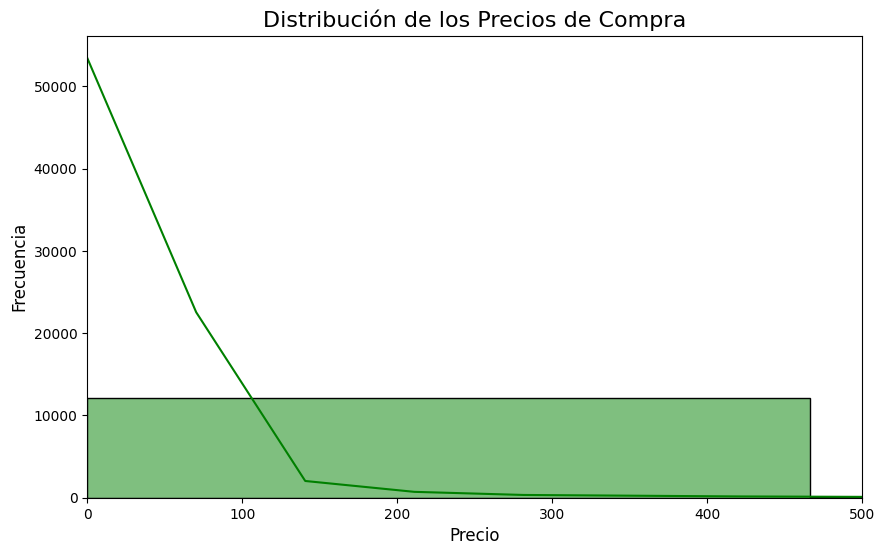

In [34]:
#Creamos Graficos para el analisis
#Distribución de los Precios de Compra
#Podemos ver los precios se concentran entre los 200 dolares 
plt.figure(figsize=(10, 6))
sns.histplot(PurchasesPrices['Price'], bins=30, kde=True, color='green')
plt.title('Distribución de los Precios de Compra', fontsize=16)
plt.xlabel('Precio', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xlim(0, 500) 
plt.show()



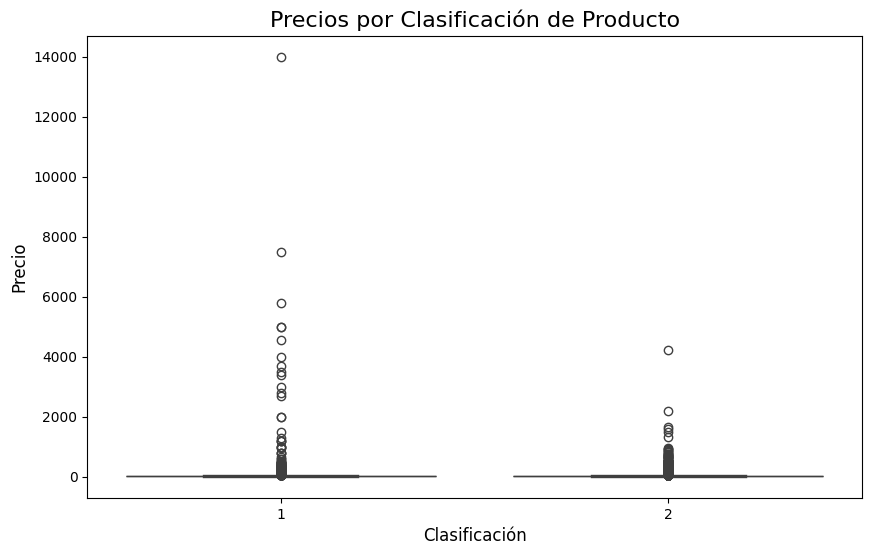

In [39]:
#Creamos la clasificación de Productos y sus Precios
#Encontramos que la clasificacion 1 tiene mayor y dispersion rango de precios 
plt.figure(figsize=(10, 6))
sns.boxplot(x='Classification', y='Price', data=PurchasesPrices)
plt.title('Precios por Clasificación de Producto', fontsize=16)
plt.xlabel('Clasificación', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.show()



In [43]:
#Renombramos, Guardamos el dataframe en tipo csv y listo para normalizar.
PurchasesPrices = PurchasesPrices.rename(columns={
    'Brand': 'BrandID',
    'Description': 'Description',
    'Price': 'Price',
    'Volume': 'Volume',
    'Classification': 'Classification',
    'PurchasePrice': 'PurchasePrice',
    'VendorNumber': 'VendorID',
    'SizeMl': 'SizeMl',
    })
PurchasesPrices.info()
PurchasesPrices.to_csv (r"C:\Users\Admin\Desktop\proyecto final\Proceso\CSV listos\PurchasesPrices.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 12256 entries, 0 to 12260
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BrandID         12256 non-null  int64  
 1   Description     12256 non-null  object 
 2   Price           12256 non-null  float64
 3   Volume          12256 non-null  float64
 4   Classification  12256 non-null  int64  
 5   PurchasePrice   12256 non-null  float64
 6   VendorID        12256 non-null  int64  
 7   SizeMl          12256 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 861.8+ KB
